# 5 - Classification on a given dataset

# Préambule :

Dans ce notebook, l'accent pour la recherche de la meilleure performance de classification a été mis sur la recherche d'hyperparamètres. Beaucoup de classifier ont été testés, avec différentes méthodes de recherche d'hyperparamètres.

# Importation des différents librairies et chargement des données

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier,  AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC, NuSVR, OneClassSVM

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
import optuna
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score





In [2]:

X_test = np.load('../data/Classification_datasets_ex5/X_test.npy')
y_test = np.load('../data/Classification_datasets_ex5/y_test.npy')
X_train = np.load('../data/Classification_datasets_ex5/X_train.npy')
y_train = np.load('../data/Classification_datasets_ex5/y_train.npy')


In [3]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# Test de plusieurs classifiers différents

On va utiliser optuna pour rechercher les meilleurs hyperparamètres.

## RandomForest Classifier

L'utilisation d'optuna permet de trouver les meilleurs hyperparamètres. Dans un premier temps, après avoir regardé dans la librairie scikit-learn le classifier random forest, nous avons pu extraire des hyperparamètres importants sur lesquels jouer.

In [4]:
def rf_objective(trial):
    # Liste d'hyperparamètres importants pour le RandomForest Classifier
    n_estimators = trial.suggest_int('n_estimators', 50, 800)
    max_depth = trial.suggest_int('max_depth', 10, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 8, 14)
    #criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes',20, 80)
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 0.5, step=0.1)
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                max_depth=max_depth, 
                                random_state=42, 
                                min_samples_split=min_samples_split, 
                                #criterion=criterion, 
                                max_leaf_nodes=max_leaf_nodes,
                                min_impurity_decrease=min_impurity_decrease)
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score
# Optimisation des hyperparamètres de Random Forest avec Optuna
rf_study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
rf_study.optimize(rf_objective, n_trials=150)
best_rf_params = rf_study.best_params
best_rf = RandomForestClassifier(**best_rf_params, random_state=42)
best_rf.fit(X_train, y_train)

[I 2024-06-21 09:33:40,871] A new study created in memory with name: no-name-0175b38d-cb49-42e4-9f53-feb46728ad2c


RandomForestClassifier(max_depth=13, max_leaf_nodes=79, min_samples_split=8,
                       n_estimators=187, random_state=42)

On test la précision sur le set de test.

In [5]:
# Test Accuracy
test_score = best_rf.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.79


0.79, c'est très loin des 0.85 demandé alors on va essayer un autre classifier, le gradient boosting.

## Gradient Boosting Classifier

Cette fois pour permettre de meilleurs résultats, on va changer la stratégie d'hyperparameter-tuning. Une fois que les hyperparamètres auront été recherché par Optuna, on va affiner notre recherche avec un gridsearch qui a une grille qui comprends des valeurs dans un intervalle relativement petit autour des valeurs trouvées par Optuna.

In [6]:
# Fonction d'objectif pour Gradient Boosting
def gbc_objective(trial):
    learning_rate = trial.suggest_categorical('learning_rate', [0.01,0.001,0.0001,0.1,1])
    max_depth = trial.suggest_int('max_depth', 10, 32)
    subsample = trial.suggest_float("subsample", 0.6, 1.0, step=0.1)
    n_ite = trial.suggest_int('n_iter_no_change', 5, 16)
    validation_fraction = trial.suggest_float('validation_fraction', 0.1, 0.3)
    min_samples_split = trial.suggest_int("min_samples_split", 6, 13)
    max_features = trial.suggest_categorical("max_features", ["log2"])
    gbc = GradientBoostingClassifier( learning_rate=learning_rate, 
                                     max_depth=max_depth, 
                                     random_state=42, 
                                     subsample= subsample,
                                    n_iter_no_change=n_ite,
                                    validation_fraction=validation_fraction,
                                    min_samples_split=min_samples_split,
                                    max_features=max_features)

    score = cross_val_score(gbc, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Optimisation des hyperparamètres de Gradient Boosting avec Optuna
gbc_study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)

gbc_study.optimize(gbc_objective, n_trials=200, show_progress_bar= True)
best_gbc_params = gbc_study.best_params
param_grid = {
    'learning_rate': [best_gbc_params['learning_rate']],
    'max_depth': [best_gbc_params['max_depth'] - 2, best_gbc_params['max_depth'], best_gbc_params['max_depth'] + 2],
    'subsample': [max(0.6, best_gbc_params['subsample'] - 0.1), best_gbc_params['subsample'], min(1.0, best_gbc_params['subsample'] + 0.1)],
    'n_iter_no_change': [max(5, best_gbc_params['n_iter_no_change'] - 2), best_gbc_params['n_iter_no_change'], min(16, best_gbc_params['n_iter_no_change'] + 2)],
    'validation_fraction': [max(0.1, best_gbc_params['validation_fraction'] - 0.05), best_gbc_params['validation_fraction'], min(0.3, best_gbc_params['validation_fraction'] + 0.05)],
    'min_samples_split': [max(6, best_gbc_params['min_samples_split'] - 2), best_gbc_params['min_samples_split'], min(13, best_gbc_params['min_samples_split'] + 2)],
    'max_features': [best_gbc_params['max_features']],
    'n_estimators': [50, 100, 150]
}
# Création du modèle GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)

# Utilisation de GridSearchCV pour affiner les hyperparamètres
grid_search = GridSearchCV(gbc, param_grid, cv=5, verbose=0, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_gbc_params_grid = grid_search.best_params_
best_gbc = GradientBoostingClassifier(**best_gbc_params_grid, random_state=42)

best_gbc.fit(X_train, y_train)
test_score = best_gbc.score(X_test, y_test)
print("Test accuracy:", test_score)

  0%|          | 0/200 [00:00<?, ?it/s]

Test accuracy: 0.774


On obtient 0.774, on va essayer un autre classifier avec un workflow légèrement différent mais toujours suivant le principe de optuna - grid search.

## KNN Classifier

On utilise aussi une Stratified K-Fold pour la crossvalidation afin que la proportion d'échantillons pour chaque classe est à peu près la même dans chaque "fold" que dans l'ensemble des données. 
On augmente aussi le nombre de trials, on peut se le permettre vu que knn Classifier est plus rapide pour l'hyperparameter tuning.

In [9]:
def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 5, 40),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': trial.suggest_int('leaf_size', 10, 100),
        'p': trial.suggest_int('p', 1, 2),
        'metric': trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan']),
    }
    
    knn = KNeighborsClassifier(**params)
    return np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy'))

# Optimisation avec Optuna
knn_study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
knn_study.optimize(objective, n_trials=3000)

# Meilleurs paramètres trouvés par Optuna
knn_best_params = knn_study.best_params

# Affinage avec GridSearchCV
param_grid = {
    'n_neighbors': [ knn_best_params['n_neighbors'] - 1, knn_best_params['n_neighbors'], knn_best_params['n_neighbors'] + 1],
    'weights': [knn_best_params['weights']],
    'algorithm': [knn_best_params['algorithm']],
    'leaf_size': [knn_best_params['leaf_size'] - 10, knn_best_params['leaf_size'], knn_best_params['leaf_size'] + 10],
    'p': [1, 2],
    'metric': [knn_best_params['metric']],
}

knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleur modèle final
best_model_knn = grid_search.best_estimator_

# Évaluation sur l'ensemble de test
y_pred = best_model_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Meilleurs paramètres Optuna : {knn_best_params}")
print(f"Meilleurs paramètres GridSearchCV : {grid_search.best_params_}")
print(f"Précision sur l'ensemble de test : {accuracy:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

Meilleurs paramètres Optuna : {'n_neighbors': 18, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 92, 'p': 1, 'metric': 'manhattan'}
Meilleurs paramètres GridSearchCV : {'algorithm': 'kd_tree', 'leaf_size': 82, 'metric': 'manhattan', 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}
Précision sur l'ensemble de test : 0.8040

Rapport de classification :
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       201
           1       0.87      0.79      0.83       299

    accuracy                           0.80       500
   macro avg       0.80      0.81      0.80       500
weighted avg       0.81      0.80      0.81       500



## SVM - SVC

On a une meilleure précision, mais toujours très loin du 0.85. Après de nombreuses recherches supplémentaires sur les différents classifier à utiliser dans la librairie scikit-learn, avec adaboost ou encore la régression logistique simple qui ne donnaient pas de bon résultats, le SVM est celui qui parassait le plus adapté à ce problème.
Le choix de Kernels disponible permettait d'avoir une bonne palette d'options à tester pour cette classification.

De nombreux paramètères sont disponibles pour les SVC de la librairie SVM et l'enjeu va être de tous les optimiser. 
On va donc prendre une plage de données assez grande dans un premier temps, et ensuite l'affiner dans le GridSearch.
Le nombre de trials est important aussi pour optuna, quand on prend une grande plage de données on va avoir besoin de plus de tests pour trouver les meilleurs hyperparamètres.

D'autres SVM sont disponibles dans la librairie scikit-learn comme nuSVC, mais leurs tests n'a pas donné de résultats concluants.

In [11]:
from sklearn.preprocessing import PowerTransformer


X_train = PowerTransformer().fit_transform(X_train)
X_test = PowerTransformer().fit_transform(X_test)



In [13]:
# Fonction d'objectif pour SVC
def objective(trial):
        params = {
        'C': trial.suggest_float('C', 1e-3, 1e3),
        'kernel': trial.suggest_categorical('kernel', [ 'poly', 'sigmoid', 'rbf']),
        'gamma': trial.suggest_float('gamma', 1e-5, 1e5),
        'degree': trial.suggest_int('degree', 2, 5),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
        'probability': trial.suggest_categorical('probability', [True, False]),
        'tol': trial.suggest_float('tol', 1e-5, 1e-1),
        'cache_size': trial.suggest_float('cache_size', 100, 1000),
        'max_iter': trial.suggest_int('max_iter', 1000, 50000),
        'decision_function_shape': trial.suggest_categorical('decision_function_shape', ['ovo', 'ovr']),
        'break_ties': trial.suggest_categorical('break_ties', [True, False]),
        'random_state': trial.suggest_int('random_state', 1, 1000),
    }
        if params['decision_function_shape'] == 'ovr':
            params['break_ties'] = trial.suggest_categorical('break_ties', [True, False])
        else:
            params['break_ties'] = False
    # Ajouter coef0 seulement pour 'poly' et 'sigmoid' kernels
        if params['kernel'] in ['poly', 'sigmoid']:
            params['coef0'] = trial.suggest_float('coef0', 0, 10)
    
        svc = SVC(**params)
        return np.mean(cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy'))


# Optimisation avec Optuna
svm_study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
svm_study.optimize(objective, n_trials=3000)

# Meilleurs paramètres trouvés par Optuna
svm_best_params = svm_study.best_params

# Affinage avec GridSearchCV
param_grid = {
    'C': [svm_best_params['C'] * 0.1, svm_best_params['C'], svm_best_params['C'] * 10],
    'kernel': [svm_best_params['kernel']],
    'gamma': [svm_best_params['gamma'] * 0.1, svm_best_params['gamma'], svm_best_params['gamma'] * 10],
    'degree': [svm_best_params['degree']],
    'class_weight': [svm_best_params['class_weight']],
    'shrinking': [svm_best_params['shrinking']],
    'probability': [svm_best_params['probability']],
    'tol': [svm_best_params['tol'] * 0.1, svm_best_params['tol'], svm_best_params['tol'] * 10],
    'cache_size': [svm_best_params['cache_size']],
    'max_iter': [svm_best_params['max_iter']],
    'decision_function_shape': [svm_best_params['decision_function_shape']],
    'break_ties': [svm_best_params['break_ties']],
    'random_state': [svm_best_params['random_state']],
}

svc = SVC(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleur modèle final
best_model = grid_search.best_estimator_

# Évaluation sur l'ensemble de test
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Meilleurs paramètres Optuna : {svm_best_params}")
print(f"Meilleurs paramètres GridSearchCV : {grid_search.best_params_}")
print(f"Précision sur l'ensemble de test : {accuracy:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

Meilleurs paramètres Optuna : {'C': 729.3578984793503, 'kernel': 'poly', 'gamma': 65912.233875172, 'degree': 3, 'class_weight': None, 'shrinking': False, 'probability': True, 'tol': 0.05973088944820115, 'cache_size': 429.2745554930947, 'max_iter': 22528, 'decision_function_shape': 'ovr', 'break_ties': True, 'random_state': 38, 'coef0': 0.9886826395299089}
Meilleurs paramètres GridSearchCV : {'C': 72.93578984793503, 'break_ties': True, 'cache_size': 429.2745554930947, 'class_weight': None, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 6591.2233875172, 'kernel': 'poly', 'max_iter': 22528, 'probability': True, 'random_state': 38, 'shrinking': False, 'tol': 0.05973088944820115}
Précision sur l'ensemble de test : 0.8500

Rapport de classification :
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       201
           1       0.93      0.81      0.87       299

    accuracy                           0.85       500
   macro avg      

On obtient bien les 0.85 demandés, on va réexécuter le code pour voir si on peut encore obtenir une meilleure précision.

In [19]:
# Fonction d'objectif pour SVC
def objective(trial):
        params = {
        'C': trial.suggest_float('C', 1e-3, 1e3),
        'kernel': trial.suggest_categorical('kernel', [ 'poly', 'sigmoid', 'rbf']),
        'gamma': trial.suggest_float('gamma', 1e-5, 1e5),
        'degree': trial.suggest_int('degree', 2, 5),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
        'probability': trial.suggest_categorical('probability', [True, False]),
        'tol': trial.suggest_float('tol', 1e-5, 1e-1),
        'cache_size': trial.suggest_float('cache_size', 100, 1000),
        'max_iter': trial.suggest_int('max_iter', 1000, 50000),
        'decision_function_shape': trial.suggest_categorical('decision_function_shape', ['ovo', 'ovr']),
        'break_ties': trial.suggest_categorical('break_ties', [True, False]),
        'random_state': trial.suggest_int('random_state', 1, 1000),
    }
        if params['decision_function_shape'] == 'ovr':
            params['break_ties'] = trial.suggest_categorical('break_ties', [True, False])
        else:
            params['break_ties'] = False
    # Ajouter coef0 seulement pour 'poly' et 'sigmoid' kernels
        if params['kernel'] in ['poly', 'sigmoid']:
            params['coef0'] = trial.suggest_float('coef0', 0, 10)
    
        svc = SVC(**params)
        return np.mean(cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy'))


# Optimisation avec Optuna
svm_study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
svm_study.optimize(objective, n_trials=1000)

# Meilleurs paramètres trouvés par Optuna
svm_best_params = svm_study.best_params

# Affinage avec GridSearchCV
param_grid = {
    'C': [svm_best_params['C'] * 0.1, svm_best_params['C'], svm_best_params['C'] * 10],
    'kernel': [svm_best_params['kernel']],
    'gamma': [svm_best_params['gamma'] * 0.1, svm_best_params['gamma'], svm_best_params['gamma'] * 10],
    'degree': [svm_best_params['degree']],
    'class_weight': [svm_best_params['class_weight']],
    'shrinking': [svm_best_params['shrinking']],
    'probability': [svm_best_params['probability']],
    'tol': [svm_best_params['tol'] * 0.1, svm_best_params['tol'], svm_best_params['tol'] * 10],
    'cache_size': [svm_best_params['cache_size']],
    'max_iter': [svm_best_params['max_iter']],
    'decision_function_shape': [svm_best_params['decision_function_shape']],
    'random_state': [svm_best_params['random_state']],
}

svc = SVC(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleur modèle final
best_model = grid_search.best_estimator_

# Évaluation sur l'ensemble de test
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Meilleurs paramètres Optuna : {svm_best_params}")
print(f"Meilleurs paramètres GridSearchCV : {grid_search.best_params_}")
print(f"Précision sur l'ensemble de test : {accuracy:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

Meilleurs paramètres Optuna : {'C': 965.7187293691553, 'kernel': 'poly', 'gamma': 77.1074854151666, 'degree': 3, 'class_weight': None, 'shrinking': True, 'probability': True, 'tol': 0.08422507408098559, 'cache_size': 799.5919297953208, 'max_iter': 45766, 'decision_function_shape': 'ovr', 'break_ties': True, 'random_state': 221, 'coef0': 0.7034405580732659}
Meilleurs paramètres GridSearchCV : {'C': 96.57187293691554, 'cache_size': 799.5919297953208, 'class_weight': None, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 7.71074854151666, 'kernel': 'poly', 'max_iter': 45766, 'probability': True, 'random_state': 221, 'shrinking': True, 'tol': 0.8422507408098558}
Précision sur l'ensemble de test : 0.8580

Rapport de classification :
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       201
           1       0.92      0.84      0.88       299

    accuracy                           0.86       500
   macro avg       0.85      0.86    

On obtient 0.8580, en réessayant plusieurs fois avec peut-être ntrials encore plus grand on peut avoir enore une meilleur précision, en affinant les paramètres d'optuna aussi, mais le résultat est là avec une précision qui dépasse celle demandée dans la consigne.

Pour finir, on peut visualiser avec yellowbrick les performances du modèle.

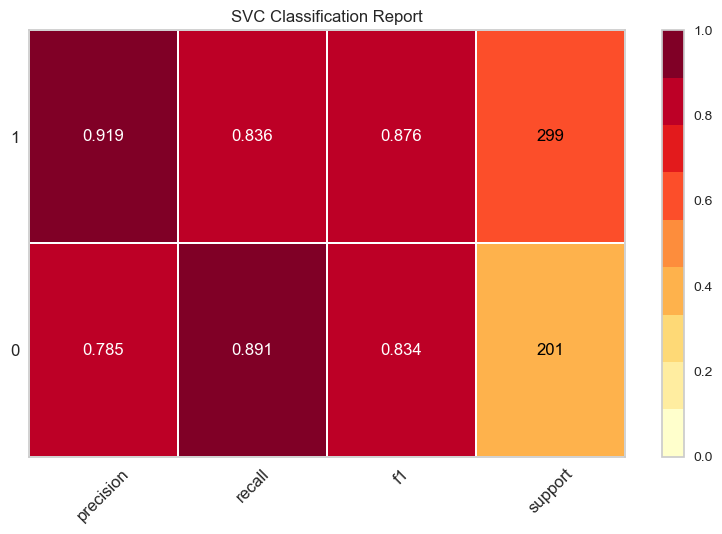

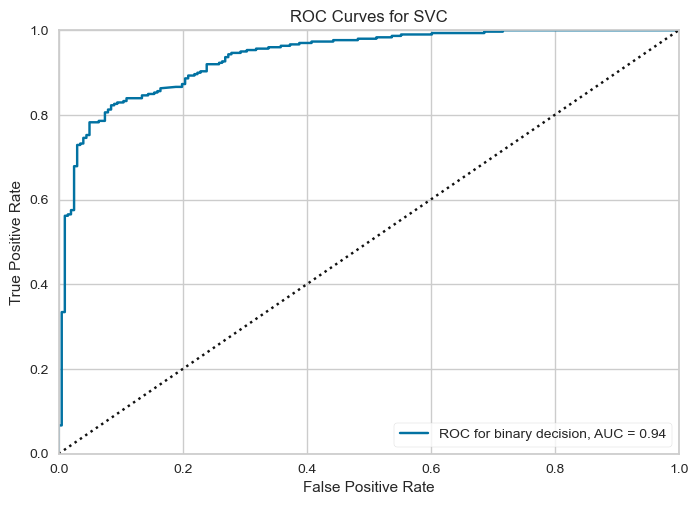

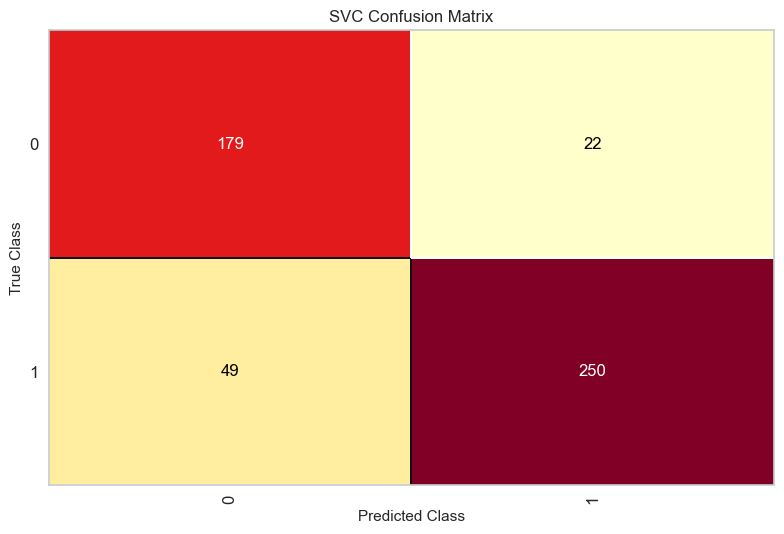

<Axes: title={'center': 'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [20]:
# Visualisation avec Yellowbrick
visualizer = ClassificationReport(best_model, support=True)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

# Visualisation de la courbe ROC
roc_auc = ROCAUC(best_model, binary=True)
roc_auc.fit(X_train, y_train)
roc_auc.score(X_test, y_test)
roc_auc.show()

# Visualisation de la matrice de confusion
cm = ConfusionMatrix(best_model)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

# Conclusion

En conclusion, nous avons testé plusieurs types de solver pour cet exercice, et il est apparu que le classifier SVM répondait le mieux au problème. On peut se demander pourquoi, voici plusieurs raisons possibles :

1. Efficacité dans les espaces à haute dimension : SVC est particulièrement efficace pour les données où le nombre de dimensions est plus grand que le nombre d'échantillons. 
2. Flexibilité grâce aux kernels : La possibilité d'utiliser différentes fonctions de noyau permet à SVC de s'adapter à divers types de problèmes en transformant les données d'une manière qui facilite la séparation des classes. Dans notre cas, le kernel poly semble être celui qui donne les meilleurs résultats.
3. Performance robuste : SVC offre de bonnes performances dans les cas où les classes sont bien séparées. Ce qui semble être le cas dans nos données, on peut le voir avec la matrice de confusion.
4. Contrôle du sur-apprentissage : Grâce au paramètre de régularisation C, le SVC peut éviter le sur-apprentissage en ajustant la pénalité pour les erreurs de classification. Cela peut-être toujours utile